In [3]:
!pip3 install cryptocompare
!pip install twilio

  Created wheel for cryptocompare: filename=cryptocompare-0.7.5-py3-none-any.whl size=5066 sha256=7d5af7e5885cbb888e9b446d6eb5241daa0c11f81523e3fdeb7f363f7df08ae9
  Stored in directory: /Users/hero/Library/Caches/pip/wheels/17/5b/b7/0b29e1ef74d0be7fc02e164e2a974a189e0423b4300c529815
Successfully built cryptocompare


In [4]:
%matplotlib inline

import networkx as nx
import numpy as np
import time
import matplotlib.pyplot as plt
import cryptocompare
import requests
import json
import pandas as pd
import os
import base64
from twilio.rest import Client
from time import sleep
from datetime import datetime
from dotenv import load_dotenv
from mpl_toolkits.mplot3d import Axes3D

load_dotenv()

True

In [5]:
account_sid = os.getenv('TWILIO_ACCOUNT_SID')
auth_token = os.getenv('TWILIO_AUTH_TOKEN')
client = Client(account_sid, auth_token)

In [14]:
def Main():
    apikey = os.getenv('apikey')
    cryptocompare_api = os.getenv('cryptocompare_api')
    
    def getUserInput():
        prompt = input('Choose profile:\n'
              '1. Binance\n'
              '2. Uniswap\n'
              '3. Gemini\n')
        return int(prompt)

    def getAddress(arg):
        addressBook = {1:'0x3f5CE5FBFe3E9af3971dD833D26bA9b5C936f0bE',
                       2:'0x88599C44e8EeB2Bbc2C1EB4749D37E09c8282d55',
                       3:'0xd24400ae8BfEBb18cA49Be86258a3C749cf46853'}
        return addressBook.get(arg)
    
    def roundNearestMinute(ts):
        return ts.dt.round('1min')
        
    def getPublicKeyTransactions():
        userInput = getUserInput()
        address = getAddress(userInput)

        getAddressTransactions = f'https://api.ethplorer.io/getAddressTransactions/{address}?limit=1000&apiKey={apikey}'
        getAddressTransactionsResponse = requests.get(getAddressTransactions).json()

        timestamp = []
        converted_timestamp = []
        hash_num = []
        value = []
        from_add = []
        to_add = []

        for transaction in getAddressTransactionsResponse:
            timestamp.append(transaction['timestamp'])
            converted_timestamp.append(datetime.fromtimestamp(transaction['timestamp']))
            hash_num.append(transaction['hash'])
            value.append(transaction['value'])
            from_add.append(transaction['from'])
            to_add.append(transaction['to'])

        ts_df = pd.DataFrame({'converted_timestamp':converted_timestamp})
        ts_series = ts_df['converted_timestamp']
        rounded_timestamp = roundNearestMinute(ts_series)
        df = pd.DataFrame({'timestamp': timestamp, 'compare_timestamp': rounded_timestamp, 'transaction_hash': hash_num, 'value_in_eth': value, 'from_address': from_add, 'to_address': to_add})
        return df
    
    def getHistoricalPrice():
        set_crypto_key = f'cryptocompare.cryptocompare._set_api_key_parameter{cryptocompare_api}'
        getHistETHPrice = cryptocompare.get_historical_price_minute('ETH', currency='USD', limit=1440)

        timestamp = []
        converted_timestamp = []
        close = []

        for time in getHistETHPrice:
            timestamp.append(time['time'])
            converted_timestamp.append(datetime.fromtimestamp(time['time']))
            close.append(time['close'])

        df = pd.DataFrame({'timestamp':timestamp, 'compare_timestamp':converted_timestamp, 'close':close}).sort_values(by=['compare_timestamp'], ascending=False)
        return df
    
    def mergeDataFrames(pk, hp):
        df = pd.merge(pk, hp, on='compare_timestamp')
        return df
    
    def createCSV(df):
        df.to_csv('getTransactionData.csv')
        
    def createPlot(df):
        timestamp = df['compare_timestamp']
        valueETH = df['value_in_eth'].to_numpy()
        priceETH = df['close'].to_numpy()

        conv_ts = []
        for times in timestamp:
            conv_ts.append(float(str(times).split()[1].replace(':',''))/100)
            
        ax = plt.axes(projection='3d')

        ax.scatter3D(conv_ts, valueETH, priceETH, c=priceETH);
        ax.set_title('Trade Flow Analysis')
        ax.set_xlabel('Time')
        ax.set_ylabel('ETH Value Transacted')
        ax.set_zlabel('Spot Price')

        stamp = int(time.time())
        filename = f'trade_flow_analysis_{stamp}.png'

        plt.savefig(filename)
        plt.show()
        
        return filename
    
    def uploadImage(filename):
        image_url = None
        with open(filename, "rb") as image:
            b64data = base64.b64encode(image.read())
            upload_result = requests.post('https://api.imgbb.com/1/upload', 
                                          data={
                                              'key': '80370e40371cc977472cb3e427f4dadb', 
                                              'image':b64data
                                          })
            image_url = upload_result.json()['data']['url']
        return image_url
    
    def sendSMS(to, media_url, body):
        message = client.messages.create(body=body, 
                                         media_url=[media_url], 
                                         from_='+18479614395', 
                                         to=to)
        

    pk_df = getPublicKeyTransactions()
    hp_df = getHistoricalPrice()
    final_df = mergeDataFrames(pk_df, hp_df)
    
    createCSV(final_df)
    png_filename = createPlot(final_df)    
    
    media_url = uploadImage(png_filename)
    sendSMS('+14124650602', [media_url], "New Trade Flow Analysis")

Choose profile:
1. Binance
2. Uniswap
3. Gemini
 3


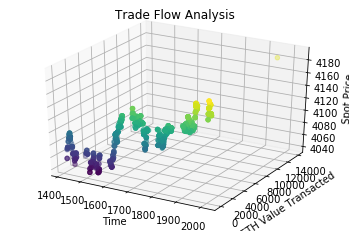

In [15]:
Main()